##Download do texto

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!cp "/content/drive/My Drive/Projetos/IA/raw_data/gu-pt_v1.txt" "gu-pt_v1.txt"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### Usando a classificação com o tensorflow

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [0]:
path_to_zip = tf.keras.utils.get_file(
    'gu-pt_v1.txt', origin='http://www.mediafire.com/folder/fsm51pinx9xcg/raw_data/gu-pt_v1.txt',
    extract=False)

path_to_file = os.path.dirname(path_to_zip)


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
   
    word_pairs = []
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  
    return zip(*word_pairs)

In [9]:
gu, pt = create_dataset('gu-pt_v1.txt', 3)

print(pt[-1])
print(gu[-1])

<start> entao deus disse que haja luz ! e a luz comecou a existir . <end>
<start> ha e gui nhanderuete aipoe i toiko hexakaa he i . ha e ramo hexakaa oiko . <end>


In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Variando o número de exemplos para treino e teste

Usaremos a divisão na forma 80-20 onde 80% são para treino e 20% para teste começando com 250 até 1500 (limite da nossa gpu).

In [0]:
trial = 5
# Try experimenting with the size of that dataset
num_examples = 1500
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('gu-pt_v1.txt', num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [41]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(1200, 1200, 300, 300)

In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [43]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
4 ----> <start>
2927 ----> magdiel
3 ----> e
1730 ----> irao
2 ----> .
9 ----> a
149 ----> regiao
33 ----> em
8 ----> que
619 ----> morava
135 ----> cada
40 ----> uma
517 ----> dessas
401 ----> tribos
515 ----> recebeu
6 ----> o
75 ----> nome
27 ----> da
34 ----> sua
1638 ----> tribo
2 ----> .
5 ----> <end>

Target Language; index to word mapping
4 ----> <start>
2496 ----> magdiel
3 ----> ha
1 ----> e
2497 ----> ira
2 ----> .
3 ----> ha
1 ----> e
6 ----> va
1 ----> e
11 ----> kuery
10 ----> ma
366 ----> edom
54 ----> pygua
202 ----> ruvixa
30 ----> ikuai
2 ----> .
3 ----> ha
1 ----> e
11 ----> kuery
156 ----> rery
10 ----> ma
753 ----> ijyvy
450 ----> hekoa
156 ----> rery
271 ----> joo
161 ----> ramigua
38 ----> ae
2 ----> .
3 ----> ha
1 ----> e
6 ----> va
1 ----> e
11 ----> kuery
10 ----> ma
366 ----> edom
11 ----> kuery
436 ----> ru
74 ----> esau
208 ----> ramymino
30 ----> ikuai
2 ----> .
5 ----> <end>


In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [45]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 95]), TensorShape([64, 94]))

### Write the encoder and decoder model
Implement an encoder-decoder model with attention which you can read about in the TensorFlow Neural Machine Translation (seq2seq) tutorial. This example uses a more recent set of APIs. This notebook implements the attention equations from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from Luong's paper.



In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [47]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 95, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [49]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 95, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [51]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2877)


# Define the optimizer and the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [0]:
def save_epoch_results(part_1, part_2):
  
  file = open('results.txt', 'a')
  file.write(part_1 + " " + part_2)
  
  file.close()
  

In [56]:
EPOCHS = 20


for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  
  part_1 = 'Trial {} Epoch {} Loss {:.4f}'.format(trial, epoch + 1,
                                      total_loss / steps_per_epoch) 
  
  part_2 = 'Time {} sec\n'.format(time.time() - start)
  
  save_epoch_results(part_1, part_2)
 
 


Epoch 1 Batch 0 Loss 2.6441
Epoch 1 Loss 2.1281
Time taken for 1 epoch 319.185935974 sec

Epoch 2 Batch 0 Loss 1.9006
Epoch 2 Loss 1.8351
Time taken for 1 epoch 52.985049963 sec

Epoch 3 Batch 0 Loss 1.7789
Epoch 3 Loss 1.7719
Time taken for 1 epoch 52.1994798183 sec

Epoch 4 Batch 0 Loss 1.6928
Epoch 4 Loss 1.6806
Time taken for 1 epoch 52.7465438843 sec

Epoch 5 Batch 0 Loss 1.5931
Epoch 5 Loss 1.5933
Time taken for 1 epoch 52.0534479618 sec

Epoch 6 Batch 0 Loss 1.5245
Epoch 6 Loss 1.5309
Time taken for 1 epoch 52.7591030598 sec

Epoch 7 Batch 0 Loss 1.4590
Epoch 7 Loss 1.4726
Time taken for 1 epoch 52.4049289227 sec

Epoch 8 Batch 0 Loss 1.4023
Epoch 8 Loss 1.4203
Time taken for 1 epoch 53.0424399376 sec

Epoch 9 Batch 0 Loss 1.3517
Epoch 9 Loss 1.3717
Time taken for 1 epoch 52.2384359837 sec

Epoch 10 Batch 0 Loss 1.3046
Epoch 10 Loss 1.3271
Time taken for 1 epoch 52.8113620281 sec

Epoch 11 Batch 0 Loss 1.2641
Epoch 11 Loss 1.2869
Time taken for 1 epoch 52.1663649082 sec

Epoch 1

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> no comeco criou deus os ceus e a terra . <end>
Predicted translation: ha e va e ma ety re . <end> 


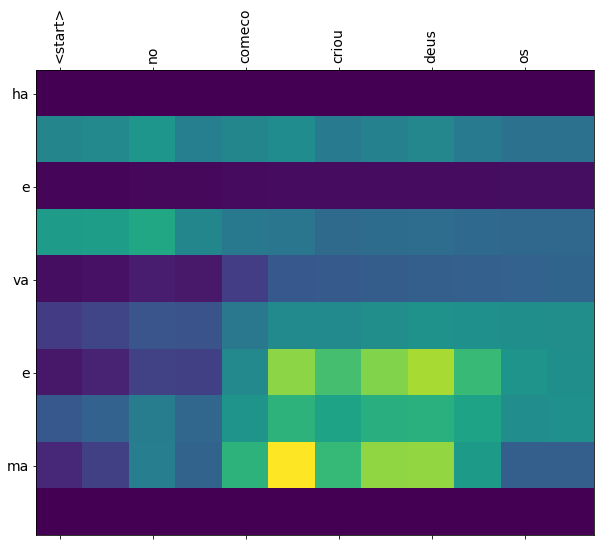

In [60]:
translate('No começo criou Deus os céus e a terra.')

In [0]:
def load_test_dataset(path, train_size, test_size):
  
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
   
    sentences = []
    original = []
    for line in lines[train_size:train_size+test_size]:
     
      test = line.split('\t')
      original.append(test[0]) 
      sentences.append(test[1]) 
      
    return original, sentences
  

In [0]:
from scipy.spatial import distance

def distance_average(senteces, results):
 
  distances =[]
  for x, y in zip(senteces, results):
    distances.append(distance.hamming(x, y))

  
  return np.mean(distances)

In [0]:
def accuracy(original, sentences):
  
  translation = []
  for sentence in sentences:

    result, sentence, attention_plot = evaluate(sentence)
    translation.append(result)

  all_tensors_x, all_tensors_y = [], []

  for transl, orig in zip(translation, original):

    original_tensor, inp_lang_tokenizer = tokenize(transl)
    translation_tensor, targ_lang_tokenizer = tokenize(orig)

    tensor_x, tensor_y = [], []

    for inp, targ in zip(original_tensor, translation_tensor):
      tensor_x.append(inp[0])
      tensor_y.append(targ[0])
    
    all_tensors_x.append(tensor_x)
    all_tensors_y.append(tensor_y)
    
   
    
    dist = distance_average(all_tensors_x, all_tensors_y)
    
    return 1-dist

In [0]:
def saving_result(treino, teste, acc):
  
  file = open("test_result.txt", 'a')

  file.write('Train ' + str(treino) + '\tTest ' + str(teste) + '\tAcc ' + str(acc) + '\n')

  file.close()

In [65]:

treino = len(input_tensor_train)
teste = len(input_tensor_val)

original, sentences = load_test_dataset('gu-pt_v1.txt', treino, teste)
acc = accuracy(original, sentences)
print(acc)

saving_result(treino, teste, acc)


0.17647058823529416
